# Calculate the pressure on the individual files

# Dask worker setup instructions

https://github.com/mrayson/pawsey-containers/tree/master/hpc-python/jupyter-sfoda

These settings do the job:

 1. `dask-scheduler --scheduler-file scheduler-$HOSTNAME.json --idle-timeout 0`
 2. `ssh localhost "cd /software/projects/pawsey0106/mrayson/projects && sbatch --ntasks=16 -c 16 start_worker.slm scheduler-$HOSTNAME.json ./"`


In [1]:
!echo $(hostname)

nid001008


In [2]:
import os
from distributed import Client
client=Client(scheduler_file='../../scheduler-' + 'nid001008' + '.json')
client

<Client: 'tcp://10.253.1.7:8786' processes=16 threads=256, memory=429.92 GiB>

In [3]:
client.restart() # This clears all data

<Client: 'tcp://10.253.1.7:8786' processes=16 threads=256, memory=429.92 GiB>

In [4]:
# from dask.distributed import Client
# from dask.distributed import LocalCluster
# cluster=LocalCluster(n_workers=32,
#         threads_per_worker=4)

# client = Client(cluster)
# cluster

In [5]:
import glob
import xarray as xr
import numpy as np
import dask.array as da
import dask

from sfoda.suntans import sunxarray as sxr
from sfoda.utils.myproj import MyProj

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-svotpowx because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [6]:
def calc_dzz(ds):
    # Calculate dzz0 - initial vertical spacing
    dz = ds['dz'].values
    #Nc = ds['Nc'].values
    Nk = ds['Nk'].values
    H = ds['dv'].values

    # Calculate dz of the near-bed layer thickness and zero layers below that
    N = ds.dims['Nc']
    K = ds.dims['Nk']
    dzz = dz[:,None] * np.ones((1,N))

    z = np.cumsum(dzz,axis=0)
    # dzbed = np.zeros((N,))
    for ii in range(N):
        k = Nk[ii]-1
        dzbed = -H[ii]+z[k,ii]
        dzz[k,ii] = dzbed
        dzz[k+1:,ii] = 0.
        #dzz[k:,ii] = 0.

    return da.from_array(dzz, chunks=(K,N))

def calc_eta(r, r0, dz, RHO0=1027.5):
    rpr = r-r0
    cff = 1/RHO0
    return (rpr*dz).sum(axis=1) * cff


def load_pressure_variables(runnum, dzz=None, rho0=None, timechunk=10):
    # Get the file names
    print(72*'#')
    print('\t File set: ',runnum)
    basedir =  '/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data{}/'.format(runnum)
    ncfiles = '{}/*.nc.*'.format(basedir)
    filenames = sorted(glob.glob(ncfiles))
    print(filenames[0], filenames[-1])
    
    # Open all of the files (drop the nan values)
    ds_all = [xr.open_dataset(ff, chunks={}).fillna(0) for ff in filenames]
    
    # Find the ghost cells
    mnptr = xr.DataArray(da.concatenate([ds['mnptr'] for ds in ds_all], axis=0))
    ghost = sxr.find_ghost_cells(mnptr)
    Nc = ghost.shape[0]
    
    # Load the grid spacing and initial density once (keep these in memory)
    #     if dzz is None:
    #         print('Calculating dzz...')
    #         dzz = da.concatenate([calc_dzz(ds) for ds in ds_all], axis=1)#.persist()
    #     if rho0 is None:
    #         print('Calculating rho0...')
    #         rho0 = da.nan_to_num(da.concatenate([(ds['rho']*1000+1000).isel(time=0) for ds in ds_all], axis=1))#.persist()

    #     nt = ds_all[0].dims['time']
    #     tsteps = np.arange(0,nt)

    #     # !!!Chunking by time here is the key to this operation fitting in memory!!!!
    #     print('Calculating steric height...')
    #     rho = da.nan_to_num(
    #         da.concatenate([(ds['rho']*1000+1000).isel(time=tsteps).chunk(time=timechunk) for ds in ds_all],axis=2))

    #     #rho = rho.persist()

    #     # Calculate the steric height
    #     eta_s = da.map_blocks(calc_eta, rho, rho0, dzz, drop_axis=1)
    #     eta_steric = eta_s[...,ghost].persist()
    
    
    if dzz is None:
        dzz = [calc_dzz(ds) for ds in ds_all]
    if rho0 is None:
        rho0 = [(ds['rho']*1000+1000).isel(time=0) for ds in ds_all]
    rho = [(ds['rho']*1000+1000) for ds in ds_all]

    eta_s_tasks = client.map(calc_eta, rho, rho0, dzz)
    eta_s = da.concatenate(client.gather(eta_s_tasks),axis=1)
    eta_steric = eta_s[...,ghost].persist()
    
    # Clear some memory - hopefully...
    #client.cancel(rho)
    
    # Load the raw sea surface height
    #eta = da.concatenate([ds['eta'] for ds in ds_all],axis=1)[...,ghost].persist()
    
    # Load all of the grid variables
    xv = da.concatenate([ds['xv'] for ds in ds_all],axis=0)[ghost]
    yv= da.concatenate([ds['yv'] for ds in ds_all],axis=0)[ghost]
    nfaces= da.concatenate([ds['nfaces'] for ds in ds_all],axis=0)[ghost]
    dv= da.concatenate([ds['dv'] for ds in ds_all],axis=0)[ghost]
    cells= da.concatenate([ds['cells'] for ds in ds_all],axis=0)[ghost,...]

    xp = ds_all[0]['xp']
    yp = ds_all[0]['yp']
    z_r = ds_all[0]['z_r']
    dz = ds_all[0]['dz']
    time = ds_all[0]['time']
    
    print(time.shape, eta_steric.shape)
    
    # Convert the coordinates
    P=MyProj('merc')
    lonv, latv = P.to_ll(xv, yv)
    lonp, latp = P.to_ll(xp, yp)

    # Create a new dataset
    dsout = xr.Dataset(
        {
        #'xv':xr.DataArray(xv, dims=('Nc',), attrs=ds_all[0]['xv'].attrs),
        #'yv':xr.DataArray(yv, dims=('Nc',), attrs=ds_all[0]['yv'].attrs),
        #'xp':xr.DataArray(xp, dims=('Np',), attrs=ds_all[0]['xp'].attrs),
        #'yp':xr.DataArray(yp, dims=('Np',), attrs=ds_all[0]['yp'].attrs),
        'xv':xr.DataArray(lonv, dims=('Nc',), attrs=ds_all[0]['xv'].attrs),
        'yv':xr.DataArray(latv, dims=('Nc',), attrs=ds_all[0]['yv'].attrs),
        'xp':xr.DataArray(lonp, dims=('Np',), attrs=ds_all[0]['xp'].attrs),
        'yp':xr.DataArray(latp, dims=('Np',), attrs=ds_all[0]['yp'].attrs),
        'dv':xr.DataArray(dv, dims=('Nc',), attrs=ds_all[0]['dv'].attrs),
        'cells':xr.DataArray(cells, dims=('Nc','numsides'), attrs=ds_all[0]['cells'].attrs),
        'nfaces':xr.DataArray(nfaces, dims=('Nc',), attrs=ds_all[0]['nfaces'].attrs),    
        'time':xr.DataArray(time, dims=('time',), attrs=ds_all[0]['time'].attrs),
        'eta_steric':xr.DataArray(eta_steric, dims=('time','Nc'), attrs=
                                {'long_name':'steric sea surface height','units':'m','location':'face'} ),
        #'eta':xr.DataArray(eta, dims=('time','Nc'), attrs=ds_all[0]['eta'].attrs)
        },
        attrs={'Description':'SUNTANS post-processed pressure fields',
              'Author':os.environ['USER'],
              })
    return dsout, dzz, rho0


In [7]:
outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr'
# outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh.zarr'


In [8]:
dzz = None
rho0=None
mode='w'
append_dim=None

for ii in range(1,13):
    dsout,dzz, rho0 = load_pressure_variables(ii, rho0=rho0, dzz=dzz )
    print('\tWriting to zarr file: ', outfile)
    #dsout.chunk({'Nc':-1,'time':1}).to_zarr(outfile, mode=mode, append_dim=append_dim, compute=True)
    dsout.chunk({'Nc':2000}).to_zarr(outfile, mode=mode, append_dim=append_dim, compute=True)

    mode='a'
    append_dim='time'
    
    # Clear memory
    client.restart()
   

########################################################################
	 File set:  1
/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data1/NWS_2km_GLORYS_hex_20130701.nc.0 /scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data1/NWS_2km_GLORYS_hex_20130701.nc.99


/opt/conda/lib/python3.10/site-packages/distributed/worker.py:4798: UserWarning: Large object of size 1.05 MiB detected in task graph: 
  (<xarray.DataArray 'rho' (time: 745, Nk: 80, Nc: 1 ... numpy.ndarray>)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


(745,) (745, 225368)
	Writing to zarr file:  /scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr
########################################################################
	 File set:  2
/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data2/NWS_2km_GLORYS_hex_20130801.nc.0 /scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data2/NWS_2km_GLORYS_hex_20130801.nc.99
(745,) (745, 225368)
	Writing to zarr file:  /scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr
########################################################################
	 File set:  3
/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data3/NWS_2km_GLORYS_hex_20130901.nc.0 /scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data3/NWS_2km_GLORYS_hex_20130901.nc.99
(721,) (721, 225368)
	Writing to zarr file:  /scratch/pawsey0106/mrayson/S

2022-08-17 07:12:37,179 - distributed.client - WARNING - Couldn't gather 9 keys, rescheduling {"('getitem-0e7e8637938fa3770899d224e876f583', 65)": (), "('getitem-0e7e8637938fa3770899d224e876f583', 117)": (), "('getitem-0e7e8637938fa3770899d224e876f583', 115)": (), "('getitem-0e7e8637938fa3770899d224e876f583', 131)": (), "('getitem-0e7e8637938fa3770899d224e876f583', 112)": (), "('getitem-0e7e8637938fa3770899d224e876f583', 85)": (), "('getitem-0e7e8637938fa3770899d224e876f583', 59)": (), "('getitem-0e7e8637938fa3770899d224e876f583', 138)": (), "('getitem-0e7e8637938fa3770899d224e876f583', 0)": ()}


	Writing to zarr file:  /scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr
########################################################################
	 File set:  6
/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data6/NWS_2km_GLORYS_hex_20131201.nc.0 /scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data6/NWS_2km_GLORYS_hex_20131201.nc.99
(745,) (745, 225368)
	Writing to zarr file:  /scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr
########################################################################
	 File set:  7
/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data7/NWS_2km_GLORYS_hex_20140101.nc.0 /scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data7/NWS_2km_GLORYS_hex_20140101.nc.99
(745,) (745, 225368)
	Writing to zarr file:  /scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2k

In [6]:
outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh.zarr'

dszarr = xr.open_dataset(outfile, engine='zarr')
dszarr

<xarray.Dataset>
Dimensions:     (Nc: 225368, numsides: 8, time: 8772, Np: 454016)
Coordinates:
  * time        (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
Dimensions without coordinates: Nc, numsides, Np
Data variables:
    cells       (Nc, numsides) int32 ...
    dv          (Nc) float64 ...
    eta_steric  (time, Nc) float64 ...
    nfaces      (Nc) int32 ...
    xp          (Np) float64 ...
    xv          (Nc) float64 ...
    yp          (Np) float64 ...
    yv          (Nc) float64 ...
Attributes:
    Author:       mrayson
    Description:  SUNTANS post-processed pressure fields

Changing the _FillValue from -999999 to 999999


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7fcf7f69d270>)

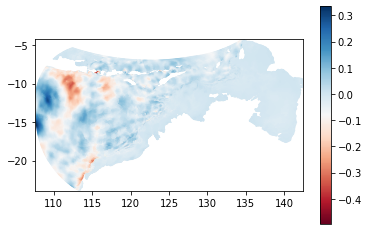

In [7]:
dszarr.suntans.plotcelldata(dszarr['eta_steric'][4400,...], cmap='RdBu')

# Write the data to acacia s3 (re-chunked along the time dimension)

In [9]:
from s3fs import S3FileSystem, S3Map

# S3 login
s3login = '/software/projects/pawsey0106/mrayson/code/s3.acacia.login'
with open(s3login) as f:
    lines = f.readlines()    
url, key, secret = [ff.strip('\n') for ff in lines[0:3]]

s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)

s3.ls('uwaoceanprocesses-suntans')

['uwaoceanprocesses-suntans/.zattrs',
 'uwaoceanprocesses-suntans/.zgroup',
 'uwaoceanprocesses-suntans/.zmetadata',
 'uwaoceanprocesses-suntans/NWS_SSH_BC_20132014.zarr',
 'uwaoceanprocesses-suntans/NWS_SSH_BC_20132014_tchunk_v2.zarr',
 'uwaoceanprocesses-suntans/cells',
 'uwaoceanprocesses-suntans/dv',
 'uwaoceanprocesses-suntans/eta_steric',
 'uwaoceanprocesses-suntans/nfaces',
 'uwaoceanprocesses-suntans/time',
 'uwaoceanprocesses-suntans/xp',
 'uwaoceanprocesses-suntans/xv',
 'uwaoceanprocesses-suntans/yp',
 'uwaoceanprocesses-suntans/yv']

CPU times: user 209 ms, sys: 35.7 ms, total: 245 ms
Wall time: 1.67 s


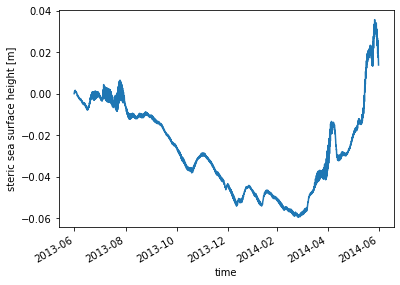

In [13]:
%%time
d = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_steric.zarr", s3=s3)
xr.open_dataset(d, engine='zarr')['eta_steric'][:,150021].plot()

CPU times: user 194 ms, sys: 40.6 ms, total: 235 ms
Wall time: 1.64 s


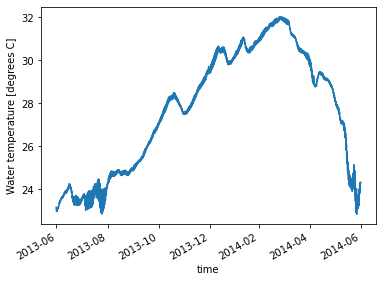

In [16]:
%%time
d = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_surface.zarr", s3=s3)
xr.open_dataset(d, engine='zarr')['temp'][:,150021].plot()

CPU times: user 124 ms, sys: 4.08 ms, total: 128 ms
Wall time: 352 ms


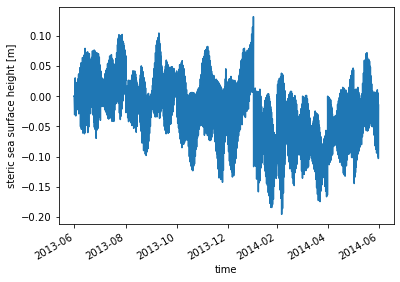

In [34]:
%%time
d = S3Map("uwaoceanprocesses-suntans/NWS_2km_GLORYS_2013_2014_ssh_tchunk.zarr", s3=s3)
xr.open_dataset(d, engine='zarr')['eta_steric'][:,15005].plot()

In [32]:
# s3.mkdir('uwaoceanprocesses-suntans-2km/')
8772/2/2

2193.0

In [8]:
# Drop non-unique time and re-chunk
# _, index = np.unique(dszarr['time'], return_index=True)
# myds = dszarr.isel(time=index).chunk({'time':-1, 'Nc':8})
# myds = dszarr.chunk({'time':2193, 'Nc':225368/8})
myds = dszarr.chunk({'time':-1, 'Nc':500})

# Load it up!
# myds = myds.persist()
myds

<xarray.Dataset>
Dimensions:     (Nc: 225368, numsides: 8, time: 8772, Np: 454016)
Coordinates:
  * time        (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
Dimensions without coordinates: Nc, numsides, Np
Data variables:
    cells       (Nc, numsides) int32 dask.array<chunksize=(500, 8), meta=np.ndarray>
    dv          (Nc) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    eta_steric  (time, Nc) float64 dask.array<chunksize=(8772, 500), meta=np.ndarray>
    nfaces      (Nc) int32 dask.array<chunksize=(500,), meta=np.ndarray>
    xp          (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv          (Nc) float64 dask.array<chunksize=(500,), meta=np.ndarray>
    yp          (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv          (Nc) float64 dask.array<chunksize=(500,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS post-processed pressure fields

In [14]:
# See the issue here: https://github.com/pydata/xarray/issues/5219
for var in myds:
    del myds[var].encoding['chunks']

In [15]:
# Save locally
outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh_tchunk.zarr'
myds.to_zarr(store=outfile, mode='w', compute=True, consolidated=True)
#outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh_tchunk.nc'
#myds.to_netcdf(outfile, mode='w')

In [16]:
outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh_tchunk.zarr'
xr.open_dataset(outfile, engine='zarr')

<xarray.Dataset>
Dimensions:     (Nc: 225368, numsides: 8, time: 8772, Np: 454016)
Coordinates:
  * time        (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
Dimensions without coordinates: Nc, numsides, Np
Data variables:
    cells       (Nc, numsides) int32 ...
    dv          (Nc) float64 ...
    eta_steric  (time, Nc) float64 ...
    nfaces      (Nc) int32 ...
    xp          (Np) float64 ...
    xv          (Nc) float64 ...
    yp          (Np) float64 ...
    yv          (Nc) float64 ...
Attributes:
    Author:       mrayson
    Description:  SUNTANS post-processed pressure fields

In [12]:
# Save time chunked output
# d = S3Map("uwaoceanprocesses-suntans-2km/NWS_2km_GLORYS_2013_2014_ssh.zarr", s3=s3)

# myds.to_zarr(store=d, mode='w', compute=True, safe_chunks=False)


KeyboardInterrupt: 

---
# Testing below here...
---

In [61]:
runnum = 5
basedir =  '/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data{}/'.format(runnum)
ncfiles = '{}/*.nc.*'.format(basedir)
filenames = sorted(glob.glob(ncfiles))
filenames[0], filenames[-1]

('/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data5/NWS_2km_GLORYS_hex_20131101.nc.0',
 '/scratch/pawsey0106/mrayson//SUNTANS_NWS_2km/NWS_2km_GLORYS_hex_Nk80dt60_2013_2014_data5/NWS_2km_GLORYS_hex_20131101.nc.99')

In [62]:
%%time
ds_all = [xr.open_dataset(ff, chunks={}).fillna(0) for ff in filenames]
ds_all[0]

CPU times: user 15.9 s, sys: 422 ms, total: 16.3 s
Wall time: 16.7 s


<xarray.Dataset>
Dimensions:       (Nc: 973, numsides: 8, Ne: 3057, Two: 2, Np: 454016, Nk: 80,
                   time: 721, Nkw: 81)
Coordinates:
    xv            (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    yv            (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    xe            (Ne) float64 dask.array<chunksize=(3057,), meta=np.ndarray>
    ye            (Ne) float64 dask.array<chunksize=(3057,), meta=np.ndarray>
    z_r           (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    z_w           (Nkw) float64 dask.array<chunksize=(81,), meta=np.ndarray>
    Nk            (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
  * time          (time) datetime64[ns] 2013-11-01T00:01:00 ... 2013-12-01
Dimensions without coordinates: Nc, numsides, Ne, Two, Np, Nkw
Data variables: (12/48)
    suntans_mesh  int64 -2147483647
    cells         (Nc, numsides) int32 dask.array<chunksize=(973, 8), meta=np.ndarray>
    face          (Nc, numsides) int32 dask.array<chunksize=(973, 8), meta=np.ndarray>
    nfaces        (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
    edges         (Ne, Two) int32 dask.array<chunksize=(3057, 2), meta=np.ndarray>
    neigh         (Nc, numsides) int32 dask.array<chunksize=(973, 8), meta=np.ndarray>
    ...            ...
    Hl            (time, Nc) float64 dask.array<chunksize=(721, 973), meta=np.ndarray>
    Hlw           (time, Nc) float64 dask.array<chunksize=(721, 973), meta=np.ndarray>
    Hsw           (time, Nc) float64 dask.array<chunksize=(721, 973), meta=np.ndarray>
    tau_x         (time, Nc) float64 dask.array<chunksize=(721, 973), meta=np.ndarray>
    tau_y         (time, Nc) float64 dask.array<chunksize=(721, 973), meta=np.ndarray>
    EP            (time, Nc) float64 dask.array<chunksize=(721, 973), meta=np.ndarray>
Attributes:
    title:    SUNTANS NetCDF output file

In [63]:
# Find the ghost cells
mnptr = xr.DataArray(da.concatenate([ds['mnptr'] for ds in ds_all], axis=0))
ghost = sxr.find_ghost_cells(mnptr)
N = ghost.shape[0]
N

246720

In [64]:
def calc_dzz(ds):
    # Calculate dzz0 - initial vertical spacing
    dz = ds['dz'].values
    Nc = ds['Nc'].values
    Nk = ds['Nk'].values
    H = ds['dv'].values

    # Calculate dz of the near-bed layer thickness and zero layers below that
    N = ds.dims['Nc']
    K = ds.dims['Nk']
    dzz = dz[:,None] * np.ones((1,N))

    z = np.cumsum(dzz,axis=0)
    # dzbed = np.zeros((N,))
    for ii in range(N):
        k = Nk[ii]-1
        dzbed = -H[ii]+z[k,ii]
        dzz[k,ii] = dzbed
        dzz[k+1:,ii] = 0.
        #dzz[k:,ii] = 0.

    return da.from_array(dzz, chunks=(K,N))

def calc_dzz_dask(ds):
    # Calculate dzz0 - initial vertical spacing
    dz = ds['dz'].values
    Nc = ds['Nc'].values
    Nk = ds['Nk'].values
    H = ds['dv'].values

    # Calculate dz of the near-bed layer thickness and zero layers below that
    N = ds.dims['Nc']
    K = ds.dims['Nk']
    dzz = dz[:,None] * np.ones((1,N))

    z = np.cumsum(dzz,axis=0)
    # dzbed = np.zeros((N,))
    for ii in range(N):
        k = Nk[ii]-1
        dzbed = -H[ii]+z[k,ii]
        dzz[k,ii] = dzbed
        dzz[k+1:,ii] = 0.
        #dzz[k:,ii] = 0.

    return da.from_array(dzz, chunks=(K,N))

# def calc_eta_s(ds, rho0, dzz, timeidx=None):
#     #dzz = calc_dzz(ds)
#     #rho0 = ds['rho'].isel(time=0)*1000+1000
#     rho = ds['rho'].isel(time=timeidx)*1000+1000
#     rhopr = rho - rho0
#     eta_s = (rhopr*dzz).sum(axis=1)
#     #eta_s = rhopr.sum(axis=1)
#     return eta_s

def calc_eta(r, r0, dz, RHO0=1027.5):
    rpr = r-r0
    cff = 1/RHO0
    return (rpr*dz).sum(axis=1) * cff


In [65]:
# Try and compute using client.scatter/gather

dzz = [calc_dzz(ds) for ds in ds_all]
rho0 = [(ds['rho']*1000+1000).isel(time=0) for ds in ds_all]


(721,)

In [78]:
nt = ds_all[0].dims['time']
tsteps = np.arange(0,nt)
rho = [(ds['rho']*1000+1000).isel(time=tsteps) for ds in ds_all]
rho[0]

<xarray.DataArray 'rho' (time: 721, Nk: 80, Nc: 973)>
dask.array<add, shape=(721, 80, 973), dtype=float64, chunksize=(721, 80, 973), chunktype=numpy.ndarray>
Coordinates:
    xv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    z_r      (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    Nk       (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2013-11-01T00:01:00 ... 2013-12-01
Dimensions without coordinates: Nc

In [79]:
#eta_s = da.map_blocks(calc_eta, rho, rho0, dzz, drop_axis=1)

eta_s_tasks = client.map(calc_eta, rho, rho0, dzz)
eta_s = da.concatenate(client.gather(eta_s_tasks),axis=1)
eta_steric = eta_s[...,ghost]

eta_steric

dask.array<getitem, shape=(721, 225368), dtype=float64, chunksize=(721, 8466), chunktype=numpy.ndarray>

In [10]:
# Load the grid spacing and initial density once (keep these in memory)
dzz = da.concatenate([calc_dzz(ds) for ds in ds_all], axis=1) #.persist()
rho0 = da.nan_to_num(da.concatenate([(ds['rho']*1000+1000).isel(time=0) for ds in ds_all], axis=1)) #.persist()


In [11]:
rho0.nbytes/1e9, dzz.nbytes/1e9

(0.1579008, 0.1579008)

In [12]:
nt = ds_all[0].dims['time']
tsteps = np.arange(0,nt)
#rho = da.nan_to_num(da.concatenate([(ds['rho']*1000+1000).isel(time=tsteps) for ds in ds_all], axis=2))

# !!!Chunking by time here is the key to this operation fitting in memory!!!!
rho = da.nan_to_num(
    da.concatenate([(ds['rho']*1000+1000).isel(time=tsteps).chunk(time=10) for ds in ds_all],axis=2))

rho

dask.array<nan_to_num, shape=(745, 80, 246720), dtype=float64, chunksize=(10, 80, 8939), chunktype=numpy.ndarray>

In [13]:
# Try map_blocks
eta_s = da.map_blocks(calc_eta, rho, rho0, dzz, drop_axis=1)
#eta_s = eta_s.persist()
eta_steric = eta_s[...,ghost]
eta_steric


dask.array<getitem, shape=(745, 225368), dtype=float64, chunksize=(10, 8466), chunktype=numpy.ndarray>

In [14]:
eta_steric.persist()

dask.array<getitem, shape=(745, 225368), dtype=float64, chunksize=(10, 8466), chunktype=numpy.ndarray>

In [16]:
client.cancel(rho)

NameError: name 'rho' is not defined

In [13]:
#eta.max(axis=1).compute()
# Load the raw sea surface height
eta = da.concatenate([ds['eta'] for ds in ds_all],axis=1)[...,ghost].persist()


In [82]:
# Load all of the grid variables
xv = da.concatenate([ds['xv'] for ds in ds_all],axis=0)[ghost]
yv= da.concatenate([ds['yv'] for ds in ds_all],axis=0)[ghost]
nfaces= da.concatenate([ds['nfaces'] for ds in ds_all],axis=0)[ghost]
dv= da.concatenate([ds['dv'] for ds in ds_all],axis=0)[ghost]
cells= da.concatenate([ds['cells'] for ds in ds_all],axis=0)[ghost,...]

xp = ds_all[0]['xp']
yp = ds_all[0]['yp']
z_r = ds_all[0]['z_r']
dz = ds_all[0]['dz']
time = ds_all[0]['time']

P=MyProj('merc')
lonv, latv = P.to_ll(xv, yv)
lonp, latp = P.to_ll(xp, yp)

# Create a new dataset
dsout = xr.Dataset(
    {
    #'xv':xr.DataArray(xv, dims=('Nc',), attrs=ds_all[0]['xv'].attrs),
    #'yv':xr.DataArray(yv, dims=('Nc',), attrs=ds_all[0]['yv'].attrs),
    #'xp':xr.DataArray(xp, dims=('Np',), attrs=ds_all[0]['xp'].attrs),
    #'yp':xr.DataArray(yp, dims=('Np',), attrs=ds_all[0]['yp'].attrs),
    'xv':xr.DataArray(lonv, dims=('Nc',), attrs=ds_all[0]['xv'].attrs),
    'yv':xr.DataArray(latv, dims=('Nc',), attrs=ds_all[0]['yv'].attrs),
    'xp':xr.DataArray(lonp, dims=('Np',), attrs=ds_all[0]['xp'].attrs),
    'yp':xr.DataArray(latp, dims=('Np',), attrs=ds_all[0]['yp'].attrs),
    'dv':xr.DataArray(dv, dims=('Nc',), attrs=ds_all[0]['dv'].attrs),
    'cells':xr.DataArray(cells, dims=('Nc','numsides'), attrs=ds_all[0]['cells'].attrs),
    'nfaces':xr.DataArray(nfaces, dims=('Nc',), attrs=ds_all[0]['nfaces'].attrs),    
    'time':xr.DataArray(time, dims=('time',), attrs=ds_all[0]['time'].attrs),
    'eta_steric':xr.DataArray(eta_steric, dims=('time','Nc'), attrs=
                            {'long_name':'steric sea surface height','units':'m','location':'face'} ),
    #'eta':xr.DataArray(eta, dims=('time','Nc'), attrs=ds_all[0]['eta'].attrs)
    },
    attrs={'Description':'SUNTANS post-processed pressure fields',
          'Author':os.environ['USER'],
          })
dsout.chunk({'Nc':-1,'time':1})

<xarray.Dataset>
Dimensions:     (Nc: 225368, Np: 454016, numsides: 8, time: 721)
Coordinates:
  * time        (time) datetime64[ns] 2013-11-01T00:01:00 ... 2013-12-01
Dimensions without coordinates: Nc, Np, numsides
Data variables:
    xv          (Nc) float64 dask.array<chunksize=(225368,), meta=np.ndarray>
    yv          (Nc) float64 dask.array<chunksize=(225368,), meta=np.ndarray>
    xp          (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yp          (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    dv          (Nc) float64 dask.array<chunksize=(225368,), meta=np.ndarray>
    cells       (Nc, numsides) int32 dask.array<chunksize=(225368, 8), meta=np.ndarray>
    nfaces      (Nc) int32 dask.array<chunksize=(225368,), meta=np.ndarray>
    eta_steric  (time, Nc) float64 dask.array<chunksize=(1, 225368), meta=np.ndarray>
Attributes:
    Description:  SUNTANS post-processed pressure fields
    Author:       mrayson

In [15]:
outfile = '$MYSCRATCH/SUNTANS_NWS_2km/NWS_2km_GLORYS_2013_2014_ssh.zarr'

mode='w'
append_dim = None
dsout.chunk({'Nc':-1,'time':1}).to_zarr(outfile, mode=mode, append_dim=append_dim)

In [17]:
dszarr = xr.open_dataset(outfile, engine='zarr')
dszarr

<xarray.Dataset>
Dimensions:     (Nc: 225368, numsides: 8, time: 745, Np: 454016)
Coordinates:
  * time        (time) datetime64[ns] 2013-07-01T00:01:00 ... 2013-08-01
Dimensions without coordinates: Nc, numsides, Np
Data variables:
    cells       (Nc, numsides) int32 ...
    dv          (Nc) float64 ...
    eta         (time, Nc) float64 ...
    eta_steric  (time, Nc) float64 ...
    nfaces      (Nc) int32 ...
    xp          (Np) float64 ...
    xv          (Nc) float64 ...
    yp          (Np) float64 ...
    yv          (Nc) float64 ...
Attributes:
    Author:       mrayson
    Description:  SUNTANS post-processed pressure fields

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7f1c8cb9dc90>)

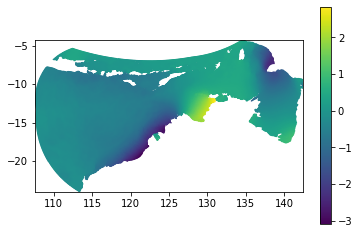

In [21]:
dszarr.suntans.plotcelldata(dszarr['eta'][500,...])

In [28]:
# Testing below here...

In [68]:
rhopr = rho -rho0
eta_s = (rhopr/RHO0*dzz).sum(axis=1)
eta_s

dask.array<sum-aggregate, shape=(2, 246720), dtype=float64, chunksize=(2, 8939), chunktype=numpy.ndarray>

In [69]:
eta_s = eta_s.persist()

In [70]:
eta_s

dask.array<sum-aggregate, shape=(2, 246720), dtype=float64, chunksize=(2, 8939), chunktype=numpy.ndarray>

In [71]:
eta = eta_s[...,ghost]
eta

dask.array<getitem, shape=(2, 225368), dtype=float64, chunksize=(2, 8466), chunktype=numpy.ndarray>

In [72]:
eta[1,:].max().compute()

0.4123845154343189

In [66]:
rhosum = rho0.sum(axis=1)
rhosum[0:10].compute()

array([2.52098078e+08, 2.52099558e+08, 2.48623227e+08, 2.46300478e+08,
       2.43189540e+08, 2.39350611e+08, 2.34222414e+08, 2.26286577e+08,
       2.19126005e+08, 2.10989397e+08])

In [85]:
def calc_eta(r, r0, dz, RHO0=1027.5):
    rpr = r-r0
    cff = 1/RHO0
    return (rpr*dz).sum(axis=1) * cff
# Try map_blocks
eta_s = da.map_blocks(calc_eta, rho, rho0, dzz, drop_axis=1)
eta_s = eta_s.persist()

In [86]:
eta = eta_s[...,ghost]
eta[1,:].max().compute()

0.41238451543431903

In [10]:
ds = ds_all[0]

eta_s = xr.concat([calc_eta_s(ds, timeidx=[500,501]) for ds in ds_all], dim='Nc')
# eta_s
# eta_s = da.concatenate([calc_eta_s(ds, timeidx=[500,]) for ds in ds_all],axis=1)

In [11]:
%%time
_ = eta_s.persist()

CPU times: user 354 ms, sys: 4.02 ms, total: 358 ms
Wall time: 357 ms


In [12]:
eta_s

<xarray.DataArray (time: 2, Nc: 246720)>
dask.array<concatenate, shape=(2, 246720), dtype=float64, chunksize=(2, 8939), chunktype=numpy.ndarray>
Coordinates:
    xv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    Nk       (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2013-07-21T20:00:00 2013-07-21T21:00:00
Dimensions without coordinates: Nc

In [13]:
eta = eta_s.isel(Nc=ghost)
eta

<xarray.DataArray (time: 2, Nc: 225368)>
dask.array<getitem, shape=(2, 225368), dtype=float64, chunksize=(2, 8466), chunktype=numpy.ndarray>
Coordinates:
    xv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(973,), meta=np.ndarray>
    Nk       (Nc) int32 dask.array<chunksize=(973,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2013-07-21T20:00:00 2013-07-21T21:00:00
Dimensions without coordinates: Nc